In [1]:
# import os
# os.environ['DISABLE_CHECKPOINTING'] = 'true'

In [2]:
import waterhealer as wh
from waterhealer import Stream
import json
import time

In [3]:
from dask.distributed import Client
client = Client('127.0.0.1:8786')

In [4]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append(json.loads(row))
        
    return results

def increment_left(rows):
    results = []
    for row in rows:
        time.sleep(1)
        row['left'] = row['data'] + 1
        results.append(row)
    return results

def increment_right(rows):
    results = []
    for row in rows:
        time.sleep(1)
        row['right'] = row['data'] + 1
        results.append(row)
    return results

def combine(tuples):
    
    left, right = tuples
    results = []
    for i in range(len(left)):
        time.sleep(1)
        results.append(left[i]['left'] + right[i]['right'])
        
    return results

In [5]:
source = Stream()
partition = source.scatter().partition_time(5)
s = partition.map(json_loads, checkpoint = True)
left = s.map(increment_left, checkpoint = True)
right = s.map(increment_right, checkpoint = True)
left.zip(right).map(combine, checkpoint = True).buffer(8).gather()

Output()

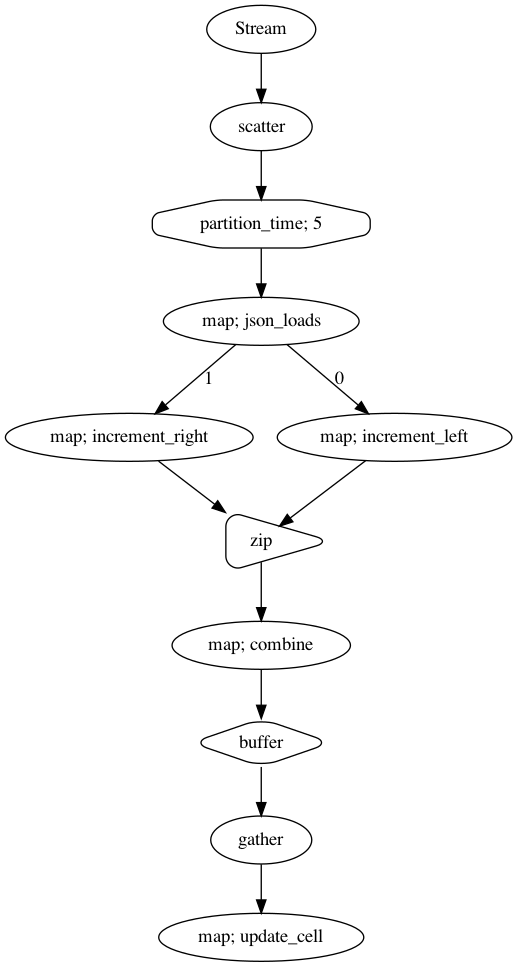

In [6]:
source.visualize()

In [7]:
for i in range(10):
    data = {'i': i, 'data': i + 1}
    source.emit(json.dumps(data))
    time.sleep(0.1)

In [11]:
source.wait()

In [12]:
source.checkpoint

{'Stream.scatter.partition_time.map.json_loads': [{'i': 0,
   'data': 1,
   'left': 2,
   'right': 2},
  {'i': 1, 'data': 2, 'left': 3, 'right': 3},
  {'i': 2, 'data': 3, 'left': 4, 'right': 4},
  {'i': 3, 'data': 4, 'right': 5, 'left': 5},
  {'i': 4, 'data': 5, 'right': 6, 'left': 6},
  {'i': 5, 'data': 6, 'right': 7, 'left': 7},
  {'i': 6, 'data': 7, 'right': 8, 'left': 8},
  {'i': 7, 'data': 8, 'right': 9, 'left': 9},
  {'i': 8, 'data': 9, 'right': 10, 'left': 10},
  {'i': 9, 'data': 10, 'right': 11, 'left': 11}],
 'Stream.scatter.partition_time.map.json_loads.map.increment_left': [{'i': 0,
   'data': 1,
   'left': 2,
   'right': 2},
  {'i': 1, 'data': 2, 'left': 3, 'right': 3},
  {'i': 2, 'data': 3, 'left': 4, 'right': 4},
  {'i': 3, 'data': 4, 'right': 5, 'left': 5},
  {'i': 4, 'data': 5, 'right': 6, 'left': 6},
  {'i': 5, 'data': 6, 'right': 7, 'left': 7},
  {'i': 6, 'data': 7, 'right': 8, 'left': 8},
  {'i': 7, 'data': 8, 'right': 9, 'left': 9},
  {'i': 8, 'data': 9, 'right': 10